In [1]:
import os 
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from skimage import io
from tqdm import tqdm
from matplotlib.patheffects import withStroke
from scipy import stats

from utils.utils import read_csv, load_config
from measurements.measurements import get_function_dict

# Functions

In [2]:
def plot_image(image, landmarks, labels=None, sizes=None, colors=None, alpha=0.5):

    fig, ax = plt.subplots(figsize=[10,10])
    plt.imshow(image, cmap='gray')
        
    ax_scat = ax.scatter(landmarks[:, 1], landmarks[:, 0], c=colors, s=sizes, alpha=alpha, edgecolor='white')

    # Define the text with a black outline
    outline_effect = withStroke(linewidth=2, foreground='black')

    if not labels is None:
        for landmark, label in zip(landmarks, labels):
            plt.text(landmark[1], landmark[0], label[0], color='white', path_effects=[outline_effect])


def plot_colorbar(cmap_name='viridis', ticks=[0,1], ticklabels=['bad', 'good']):

    # Create a figure and a blank subplot (dummy axes) for the colorbar
    fig, ax = plt.subplots(figsize=(0.2, 10)) 
    cmap = plt.get_cmap(cmap_name)  
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    # Create a ScalarMappable object with the colormap and normalization
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array for the ScalarMappable

    # Plot the colorbar in the dummy subplot
    cbar = plt.colorbar(sm, cax=ax, orientation="vertical")
    cbar.set_ticks(ticks)                
    cbar.set_ticklabels(ticklabels) 
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(13)  
    #cbar.set_ticklabels(["", ""]) 

    plt.text(
        -1.05, 0.5, 'Mean', va='center', ha='center', rotation=90,
        transform=plt.gca().transAxes, fontsize=18
    )
    
    plt.tight_layout()



def plot_circles(num_circles=5, circle_radius=50, labels=['1.00cm', '0.90cm']):

    # Define the number of circles and their sizes
    circle_sizes = [circle_radius * (i + 1) for i in reversed(range(num_circles))]  # Decreasing size

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(5, 10))

    # Set the axis limits to accommodate the circles
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, num_circles + 1)

    # Plot circles in a vertical row with increasing size
    for i, size in enumerate(circle_sizes):
        ax.scatter(0, i + 1, s=size, color='black', edgecolor='black')

    # Add labels to the top and bottom circles
    ax.text(0.2, 1, labels[0], va='center', ha='left', fontsize=12)
    ax.text(0.2, num_circles, labels[1], va='center', ha='left', fontsize=12)
    ax.text(-0.5, (num_circles+1)/2, 'Variability', va='center', ha='left', fontsize=1, rotation=90)

    # Remove axis for cleaner appearance
    ax.axis('off')
    ax.set_aspect('equal')

    # Adjust layout to reduce whitespace
    #plt.subplots_adjust(left=0.3, right=0.7, top=0.9, bottom=0.1)

    plt.tight_layout()

# Distance calculation and plots

In [42]:
# Load the config and landmark names
config_tag = 'feet_lateral_bulk40'
config = load_config(config_tag, config_path=r'C:\Users\deschweiler\Documents\KneeMRI_PatellofemoralMeasurements\roma_medical\experiment_config_windows.json')
function_dict, kpt_names = get_function_dict(config['mode'])
reference_ids = config['reference_ids']

kpt_name = kpt_names[:26]

# Overwrite experiment folder if necessary
# config['experiment_folders'] = ['D:\experiments\ROMA_FeetAPAlex_Bulk50_ref62']

# exlude ids
exclude_ids = ['1000000001335799_0000117190_Y_LEFT', # one landmark missing
               '1000000001088769_9191304201_LATERAL_EXTRA_LEFT', # one landmark missing
               '1010500001896852_0000623603_AP_EXTRA_LEFT', # measurement (Felix) faulty?
               ]

# Find files and process
pred_files = []
for folder in config['experiment_folders']:
    pred_files.extend(glob.glob(os.path.join(config['experiment_root'], folder, '*matches.csv')))
print('{0} prediction files found...'.format(len(pred_files)))

annotation_files = []
for annotation_path in config['annotation_paths']:
    annotation_files.extend(glob.glob(os.path.join(annotation_path, '*_landmarks.csv')))
print('{0} annotation files found...'.format(len(annotation_files)))

distance_dict = {}
for label in kpt_names:
    distance_dict[' - '.join(label)] = []

for pred_file in tqdm(pred_files):

    # identify corresponding ground truth annotation file
    ids = os.path.split(pred_file)[-1].replace('_matches.csv','').split('_to_')

    if ids[0] in exclude_ids or ids[1] in exclude_ids:
        print(f'Excluding {ids[0]} to {ids[1]} by definition.')
        continue

    if not ids[0] in reference_ids and not reference_ids is None:
        continue

    src_file = [f for f in annotation_files if os.path.split(f)[-1].startswith(f'{ids[1]}_')]
    if len(src_file)==0:
        print(f'Skipping {ids[0]} to {ids[1]} - no ground truth annotations found.')
        continue
    src_file = src_file[0]
    
    # load prediction and ground truth
    prd_kpts = read_csv(pred_file)
    prd_kpts = np.array([[float(x),float(y)] for x,y in prd_kpts])
    src_kpts = read_csv(src_file)
    src_kpts = np.array([[float(x)*config['landmark_scaling'][1],float(y)*config['landmark_scaling'][0]] for x,y in src_kpts])

    # calculate distances
    dists = np.linalg.norm(src_kpts-prd_kpts, axis=1)
    dists[prd_kpts[:,0]==0] = np.nan

    # if any([d*config['mpp']>10 for d in dists]):
    #     print(f'Pred: {pred_file}\nSource: {src_file}')
    
    # save distances
    for d,label in zip(dists, kpt_names):
        distance_dict[' - '.join(label)].append(d*config['mpp'])


100 prediction files found...
100 annotation files found...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 99.09it/s]


In [43]:
# Save distance_dict to file
import json
with open(r'E:\experiments\MSK_Landmarks_2D\landmark_accuracy_{0}.json'.format(config_tag), 'w') as f:
    json.dump(distance_dict, f)

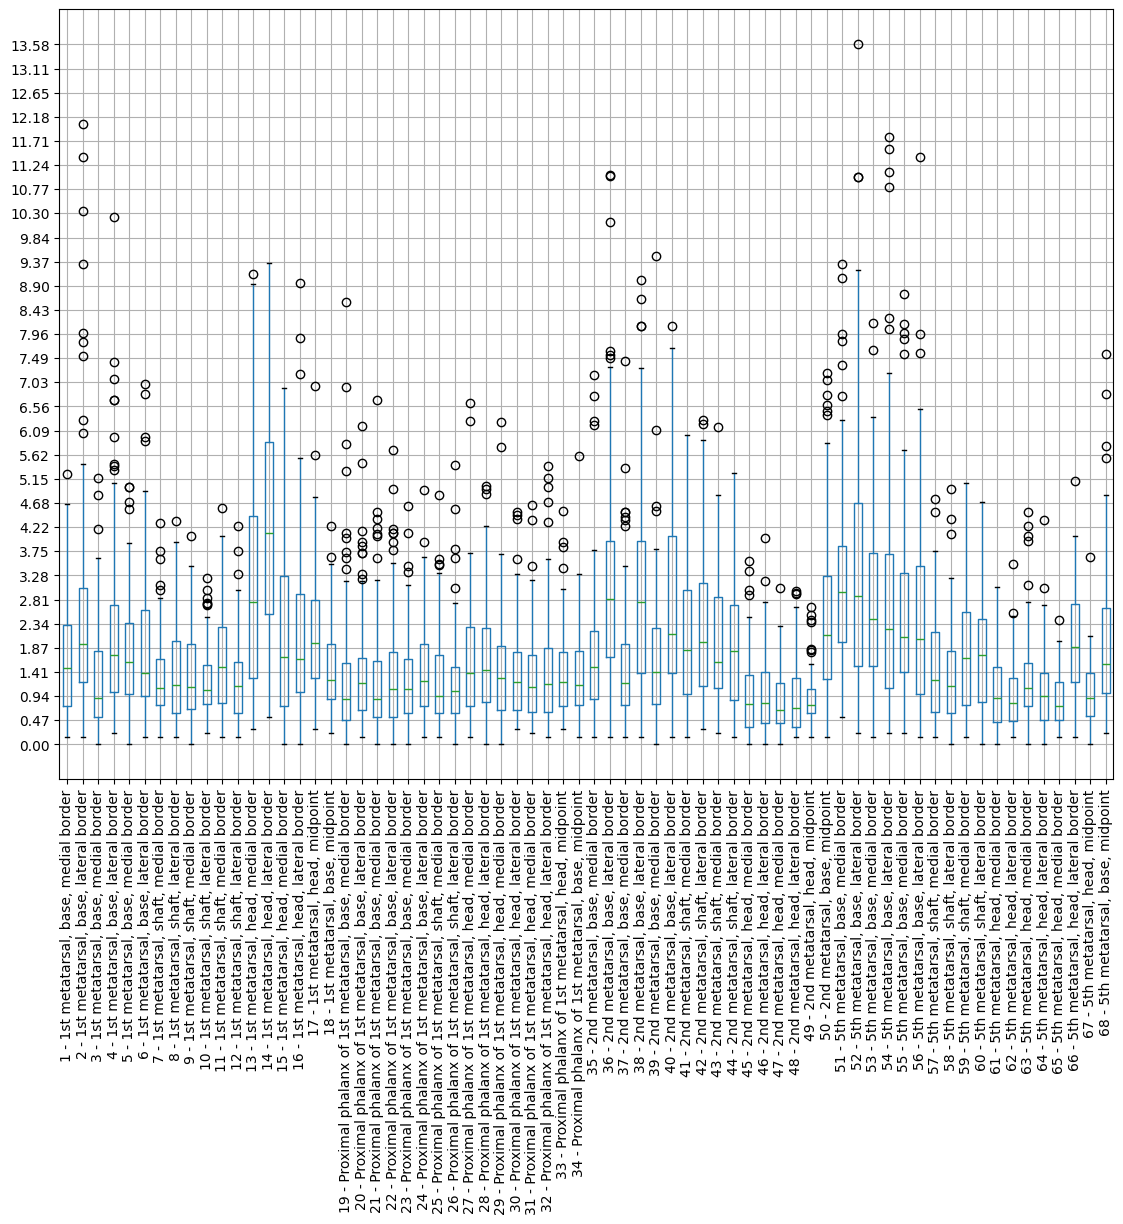

In [8]:
dist_dataframe = pd.DataFrame(distance_dict)
dist_dataframe.boxplot(rot=90, fontsize=10, figsize=[dist_dataframe.shape[1]*0.2,10])
yticks = np.linspace(0, dist_dataframe.max().max(), 30)
plt.yticks(yticks, labels=[f'{t:.2f}' for t in yticks])
plt.show()

In [9]:
# Perform analysis on the global-level
distances_all = [value for sublist in distance_dict.values() for value in sublist]
distances_all_mean = np.mean(distances_all)
distances_all_std = np.std(distances_all)
distances_all_ci95 = stats.t.interval(0.95, len(distances_all)-1, loc=np.mean(distances_all), scale=stats.sem(distances_all))
distances_all_perc = np.percentile(distances_all, [5,95])
print(r"Total number of landmarks: {0} with a distance of {1:.2f} +/- {2:.2f} [{3:.2f},{4:.2f}]".format(len(distances_all), distances_all_mean, distances_all_std, *distances_all_ci95))

# Perform analysis on label-level
distances_mean = [np.nanmean(distance_dict[key]) for key in distance_dict.keys()]
distances_median = [np.nanmedian(distance_dict[key]) for key in distance_dict.keys()]
distances_std = [np.nanstd(distance_dict[key]) for key in distance_dict.keys()]

distances_ci95 = [stats.t.interval(0.95, len(distance_dict[key])-1, loc=np.mean(distance_dict[key]), scale=stats.sem(distance_dict[key])) for key in distance_dict.keys()]

distances_perc5 = [np.nanpercentile(distance_dict[key], 2.5) for key in distance_dict.keys()]
distances_perc95 = [np.nanpercentile(distance_dict[key], 97.5) for key in distance_dict.keys()]
kpt_fail = [np.sum(np.isnan(distance_dict[key])) for key in distance_dict.keys()]
print("Number of files: {0}".format(len(distance_dict[list(distance_dict.keys())[0]])))

dist_dict = {'Labels':[k[1] for k in kpt_names], 'Mean':distances_mean, 'Median':distances_median, 'Variance':distances_std, '95%CI': [f'[{d[0]:.2f},{d[1]:.2f}]' for d in distances_ci95], '2.5%':distances_perc5, '97.5%':distances_perc95, 'Fail':kpt_fail}
dist_df = pd.DataFrame(dist_dict)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
dist_df

Total number of landmarks: 6664 with a distance of 1.77 +/- 1.51 [1.74,1.81]
Number of files: 98


,Labels,Mean,Median,Variance,95%CI,2.5%,97.5%,Fail
0,"1st metatarsal, base, medial border",1.65,1.48,1.10,"[1.43,1.87]",0.21,4.36,0
1,"1st metatarsal, base, lateral border",2.57,1.96,2.34,"[2.10,3.04]",0.34,9.92,0
2,"1st metatarsal, base, medial border",1.26,0.91,1.06,"[1.05,1.48]",0.06,3.94,0
3,"1st metatarsal, base, lateral border",2.26,1.74,1.83,"[1.89,2.63]",0.38,6.92,0
4,"1st metatarsal, base, medial border",1.81,1.61,1.12,"[1.58,2.04]",0.34,4.64,0
5,"1st metatarsal, base, lateral border",1.92,1.38,1.47,"[1.62,2.22]",0.26,5.93,0
6,"1st metatarsal, shaft, medial border",1.33,1.09,0.82,"[1.16,1.50]",0.30,3.39,0
7,"1st metatarsal, shaft, lateral border",1.41,1.15,0.94,"[1.22,1.60]",0.34,3.38,0
8,"1st metatarsal, shaft, medial border",1.38,1.12,0.85,"[1.21,1.55]",0.34,3.10,0
9,"1st metatarsal, shaft, lateral border",1.23,1.06,0.67,"[1.10,1.37]",0.34,2.80,0


# Visual representation of prediction accuracy

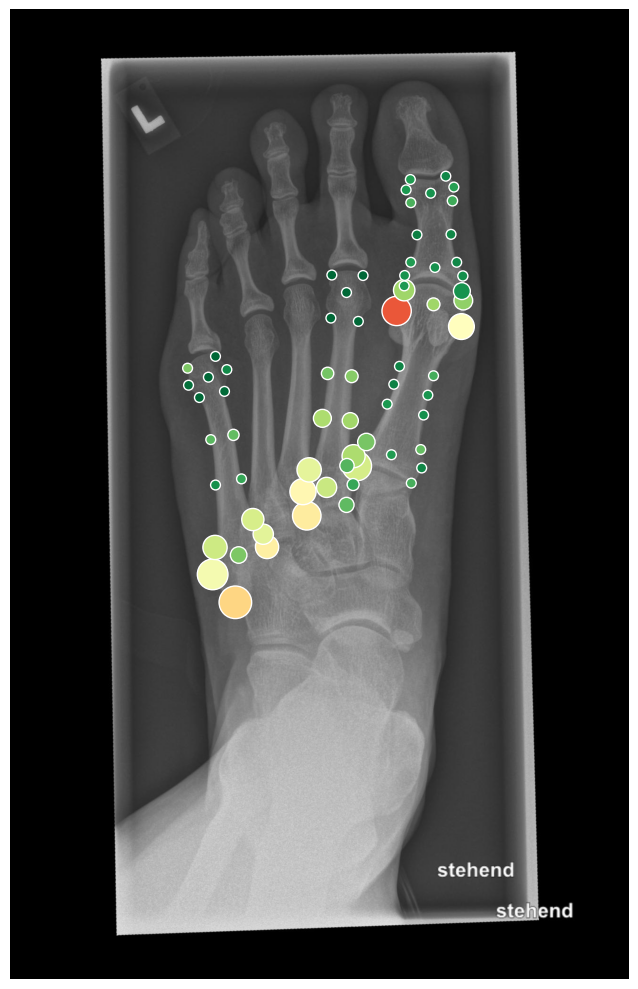

C:\Users\DEschweiler\AppData\Local\Temp\ipykernel_19752\1496738868.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


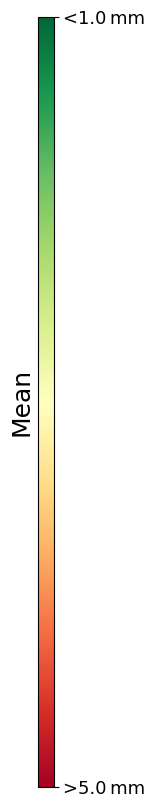

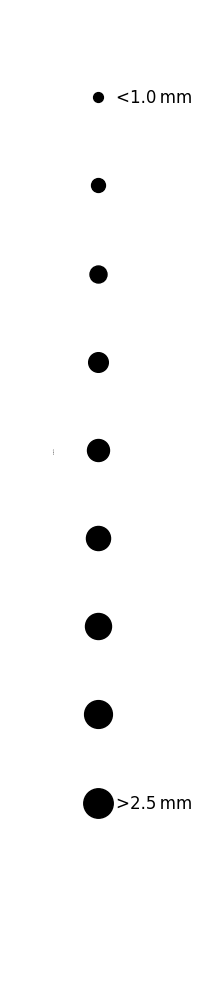

In [196]:
circle_diameter = 500
cmap_name = 'RdYlGn'
dist_range = np.array([1, 5])
variance_range = np.array([1, 2.5])

# Get data
representative_image = io.imread(config['representative_image_file'])
representative_landmarks = read_csv(config['representative_landmark_file'])
representative_landmarks = np.array([[float(y)*config['landmark_scaling'][0],float(x)*config['landmark_scaling'][1]] for x,y in representative_landmarks])

# Plot color-coded mean distances and size-coded spreads
if dist_range is None:
    dist_range = np.percentile(distances_mean, [5,95])

error = (distances_mean-dist_range[0]) / (dist_range[1]-dist_range[0])
error = np.clip(error, 0, 1)
cmap = plt.get_cmap(cmap_name)
accuracy_colors = cmap(1-error)

variance_sizes = (distances_std-variance_range[0]) / (variance_range[1]-variance_range[0])
variance_sizes = np.clip(variance_sizes, 0.1, 1.1)
variance_sizes = np.array([d*circle_diameter for d in variance_sizes])

plot_image(representative_image, representative_landmarks, labels=None, sizes=variance_sizes, colors=accuracy_colors, alpha=1.0)
plt.axis('off')
plt.tight_layout()
plt.savefig(r'C:\Users\DEschweiler\Documents\Publications\EuropeanRadiology2024_MedicalLandmarkMatching\landmark_precision\{0}.svg'.format(config_tag))
plt.show()
plot_colorbar(cmap_name=cmap_name, ticks=[0,1], ticklabels=['>{0:.1f}\u2009mm'.format(dist_range[1]), '<{0:.1f}\u2009mm'.format(dist_range[0])])
plt.savefig(r'C:\Users\DEschweiler\Documents\Publications\EuropeanRadiology2024_MedicalLandmarkMatching\landmark_precision\legend_color.svg')
plt.show()
plot_circles(num_circles=9, circle_radius=50, labels=['>{0:.1f}\u2009mm'.format(variance_range[1]), '<{0:.1f}\u2009mm'.format(variance_range[0])])
plt.savefig(r'C:\Users\DEschweiler\Documents\Publications\EuropeanRadiology2024_MedicalLandmarkMatching\landmark_precision\legend_size.svg')
plt.show()

### Calculate scores for specific landmarks

In [15]:
for function_key in function_dict:

    landmark_ids = function_dict[function_key][2]()
    distances_specific = []
    keys_specific = []
    for key in distance_dict.keys():
        if any([key.startswith(f'{l} - ') for l in landmark_ids]):
            distances_specific.extend(distance_dict[key])
            keys_specific.append(key)

    print("Total number of landmarks for \"{0}\": {1} with a distance of ${2:.2f}\pm{3:.2f}$ [{4:.2f};{5:.2f}]".format(function_key, len(distances_specific), np.mean(distances_specific), np.std(distances_specific), *stats.t.interval(0.95, len(distances_specific)-1, loc=np.mean(distances_specific), scale=stats.sem(distances_specific))))
    #print("Considered keys:\n"+ '\n'.join(keys_specific))

Total number of landmarks for "Medial Arch Angle": 72 with a distance of $3.64\pm4.24$ [2.64;4.65]
Total number of landmarks for "Talus-First Metatarsal Angle": 144 with a distance of $4.39\pm3.75$ [3.77;5.02]
Total number of landmarks for "Calcaneal Inclination Angle": 72 with a distance of $3.02\pm2.47$ [2.44;3.60]
Total number of landmarks for "Medial Arch Angle (robust)": 144 with a distance of $3.65\pm3.77$ [3.03;4.27]
Total number of landmarks for "Talus-First Metatarsal Angle (robust)": 648 with a distance of $3.85\pm3.36$ [3.59;4.11]
Total number of landmarks for "Calcaneal Inclination Angle (robust)": 144 with a distance of $3.34\pm2.89$ [2.86;3.82]
Total number of landmarks for "Calcaneal Inclination Angle v": 180 with a distance of $5.10\pm4.62$ [4.41;5.78]


#### Calculate overall landmark matching accuracy from json files 

In [48]:
matching_dir = r'E:\experiments\MSK_Landmarks_2D'
# matching_files = ['landmark_accuracy_feet_ap_bulk40.json', 'landmark_accuracy_feet_lateral_bulk40.json', 'landmark_accuracy_shoulder_ap_bulk40.json', 'landmark_accuracy_knee_ap_bulk40.json', 'landmark_accuracy_knee_lateral_bulk40.json', 'landmark_accuracy_knee_axial_bulk40.json']
matching_files = ['landmark_accuracy_knee_ap_bulk40.json', 'landmark_accuracy_knee_lateral_bulk40.json', 'landmark_accuracy_knee_axial_bulk40.json']

matching_scores = []
for matching_file in matching_files:
    with open(os.path.join(matching_dir, matching_file), 'r') as f:
        matching_data = json.load(f)
        for key in matching_data.keys():
            matching_scores.extend(matching_data[key])

matching_scores_mean = np.mean(matching_scores)
matching_scores_std = np.std(matching_scores)
print(f'Matching Scores - Mean: {matching_scores_mean}, Std: {matching_scores_std} (from {len(matching_scores)} samples)')


Matching Scores - Mean: 2.6098987448229316, Std: 2.9777794050784054 (from 5880 samples)
